## Introduction

## Table of contents:
* [1.Introduction](#intro)
* [2.Getting the data](#first-bullet)
    * [2.1.The Airbnb (unofficial) API](#second-bullet)
    * [2.2.Creating Rest calls](#third-bullet)
    * [2.3.Extracting the data](#extracting)
* [3.Exploring the data](#explore)
    * [3.1.Exploring location](#geodata)
* [3.2.Findings](#third-bullet)

## Introduction <a class="anchor" id="intro"></a>

## Getting the data <a class="anchor" id="first-bullet"></a>

This project is meant to be part of a bigger project in which I will create a web app to help users find the cheapest accomodation near them. However, I thought it would be an interesting exercise to also analyse how different is the accomodation market between a major city like London and a smaller one (i.e. the one I live in Belfast). It is also a great way to brush up some EDA, statistics and (maybe) machine learning models. Let's see what I come up with :)

The first task is to get the data, there are probably already Airbnb datasets online but I wanted to create my own. So in this first part, I will quickly illustrate how I went about gathering listing data for London and Belfast.

### The Airbnb (unofficial) API <a class="anchor" id="second-bullet"></a>

I have built few scrapers in the past so I thought I would continue to use <i>BeautifulSoup</i> and <i>Selinimum</i> to capture the data I wanted. In doing so, I was able to capture: prices, name of listing, review counts, ratings, individual listing id, etc. However, the approximate location per listing was very vague as London is a very big city. Therefore I also needed to capture approximate <b>lat</b> and <b>lng</b> of the listing (something I couldn't do via normal scraper).<br>For this reason I thought to open the good old Chrome Dev Tool for network interception.

![Network Intercept](imgs/network_intercept.png "Network Intercept")

Let me tell you, Airbnb does a big job in not letting users get data outside the normal web browser. After trail and error I was able to query their v3 of the ExploreSearch endpoint on a jupyter, however I couldn't figure out why my headers were only valid for that particular request, changing a parameter (e.g. itemsoffset) would result in 429 or 404 request. After some investigation in the interwebs,I thought this could be due cookies or the fact that I needed to learn about GraphQL to get a better understanding of what is going on. However, I still wanted to scrape using the classic REST requests, so I looked up on the internet if I could find a v2 or v1 of these apis as I was sure those wouldn't give me the same type of errors. <br> It is at this stage that I found about https://stevesie.com/.

### Creating the REST calls <a class="anchor" id="second-bullet"></a>

 Steve has documented several key endpoints from v2 of Airbnb apis, all I had to do was using those suggested headers and create <b>session requests objects with retry</b> logic. Below the header object we will use during the session.

In [2]:
headers = {
    'Accept':'application/json'
,'Accept-Encoding':'gzip, deflate'
,'Accept-Language':'en-us'
,'Cache-Control':'no-transform'
,'Charset':'UTF-8'
,'Content-Type':'application/json'
,'Referer':'http://Airbnb/'
,'User-Agent':'Airbnb/17.49 iPodtouch/10.2 Type/Phone'
,'X-Airbnb-API-Key':'d306zoyjsyarp7ifhu67rjxn52tv0t20'
,'X-Airbnb-Currency':'GBP'
,'X-Airbnb-Locale':'en'
,'X-Airbnb-Meta-interaction-type':'dateChanged'
,'X-Airbnb-Network-Type':'wifi'
,'X-HTTP-METHOD-OVERRIDE':'PUT'
,'X-HTTP-Method-Override':'GET'
,'bundleID':'com.apple.AdSheet'
,'device':'iPod7,1'
,'os_Version':'iOS 10.2'
}

Once the header was set, I simply had to construct the GET request. Example below:

In [6]:
location = 'London'
items_offset = 0
checkout = '2022-02-19'
checkin = '2022-02-18'
price_min = 17
price_max = 21

url =('https://api.airbnb.com/v2/explore_tabs?_format=for_explore_search_web'
        '&items_per_grid=50'
        '&location={}'
        '&section_offset=4'
        '&supports_for_you_v3=true'
        '&tab_id=home_tab&timezone_offset=300&version=1.3.4'
        '&items_offset={}'
        '&checkin={}&checkout={}'
        '&price_min={}&price_max={}'
        '&currency=GBP').format(location,items_offset,checkout,checkin,price_min,price_max)
url

'https://api.airbnb.com/v2/explore_tabs?_format=for_explore_search_web&items_per_grid=50&location=London&section_offset=4&supports_for_you_v3=true&tab_id=home_tab&timezone_offset=300&version=1.3.4&items_offset=0&checkin=2022-02-19&checkout=2022-02-18&price_min=17&price_max=21&currency=GBP'

 It is important to note that the maximum number of records you will be able to extract with any combination of search filters for each request will always be 300. So you will need to dynamically adjust your request parameters to extract as much of those subsequent listings as possible. The number of total available listings per request will be shown in the listings_count from the json response object. If the number is less than 300, then you can get all the listings by simply adjusting the <b>itemsoffset</b> param, otherwise you will have to introduce other filters. In my case, I have adjusted <b>price_min</b> and <b>price_max</b> and if the listing_count for that request was greater than 300, I also introduced the <b>property_type_id</b> filter. In this way, I wasn't able to capture 100% of the listings available but I certantly a good 90-95% of it. <br>Two important things you might want to consider:
- if listing_counts returns 1001, that means that there actually way more listings but you will only be able to extract up to the first 1001 listings.
- it is also important that you set <b>checkin</b> and <b>checkout</b> params as well, failing to do so will result in the response object not having any <i>pricing</i> info.

In summary we need:
- a function to dynamically create url request as needed. <i>create_url</i>
- a function to extract the first 300 results from initial get request. <i>get_first_300_results</i>
- a function to extract the subsequent pages using additional filters (in my case property_type_id). <i>property_type_search</i>
- a function to parse the json response to a dataframe object. <i>parse_data</i>
- use sessions for keep-alive connections with retry logic (as Airbnb will lock us out many times during this process, thankfully we got ExpressVPN so no need for proxies :) ).


The libs used in this project.

In [2]:
import pandas as pd
import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

Creating the retry object.

In [15]:
retry_strategy = Retry(
    total=9,
    backoff_factor=0.3, #1
    status_forcelist=[429, 500, 502, 503, 504],
    method_whitelist=["HEAD", "GET", "OPTIONS"]
)
adapter = HTTPAdapter(max_retries=retry_strategy)

client = requests.Session()
client.mount("https://", adapter)
client.mount("http://", adapter)

Our first helper function used to dynamically create the url we need. At this stage filters include: checkin and checkout dates, price_min and price_max for night stay and type of property.

In [5]:
def create_url(location,items_offset,checkout,checkin,price_min,price_max,p_type_1=None,p_type_2=None,p_type_3=None,p_type_4=None,p_type_5=None,p_type_6=None,p_type_7=None,property_url=False):
    if property_url == False:
        # property_url will be True if initial request returned more than 300 listings.
        url =('https://api.airbnb.com/v2/explore_tabs?_format=for_explore_search_web'
        '&items_per_grid=50'
        '&location={}'
        '&section_offset=4'
        '&supports_for_you_v3=true'
        '&tab_id=home_tab&timezone_offset=300&version=1.3.4'
        '&items_offset={}'
        '&checkin={}&checkout={}'
        '&price_min={}&price_max={}'
        '&currency=GBP').format(location,items_offset,checkout,checkin,price_min,price_max)
        return url
    url =('https://api.airbnb.com/v2/explore_tabs?_format=for_explore_search_web'
        '&items_per_grid=50'
        '&location={}'
        '&section_offset=4'
        '&supports_for_you_v3=true'
        '&tab_id=home_tab&timezone_offset=300&version=1.3.4'
        '&items_offset={}'
        '&checkin={}&checkout={}'
        '&price_min={}&price_max={}'
        '&currency=GBP'
        '&property_type_id[]={}'
        '&property_type_id[]={}'
        '&property_type_id[]={}'
             ).format(location,items_offset,checkout,checkin,price_min,price_max,p_type_1,p_type_2,p_type_3)
    return url

The below functions are used to capture the first 300 results given the initial url. The get_next_pages function is to look for the subsequent page responses by tweaking the <b>items_offset</b> param and checking the <b>pagination_metadata</b> response object.

In [25]:
def get_first_300_results(url):
    global listings_count
    r= client.get(url,headers=headers)
    if r.status_code!=200:
        print(r)
    data = r.json()
    listings_count = data['explore_tabs'][0]['home_tab_metadata']['listings_count']
    info_extraction()
    print('\nExtracting first page results.')
    parsed_df = pd.DataFrame()
    #print(url)
    parsed_df = pd.concat([parsed_df,parse_data(data)])
    parsed_next_df = get_next_pages(data,url_flag=False)
    parsed_df = pd.concat([parsed_df,parsed_next_df])
    print('Extracted {} listings'.format(parsed_df.shape[0]))
    return {'parsed_df':parsed_df,'data':data,'listings_count':listings_count}

def get_next_pages(data,url_flag=False,p_type_1=None,p_type_2=None,p_type_3=None,p_type_4=None,p_type_5=None,p_type_6=None,p_type_7=None,property_url=False):
    parsed_next_df = pd.DataFrame()
    print('\nExtracting subsequent page results')
    while True:
        meta_base = data['explore_tabs'][0]['pagination_metadata']
        has_next_page = meta_base['has_next_page']
        if has_next_page==False:
            break
        items_offset = meta_base['items_offset']
        if url_flag==False:
            url = create_url(location,items_offset,checkout,checkin,price_min,price_max)
        else:
            url = create_url(location,items_offset,checkout,checkin,price_min,price_max,p_type_1,p_type_2,p_type_3,p_type_4,p_type_5,p_type_6,p_type_7,property_url=True)
        #print(url)
        r= client.get(url,headers=headers)
        if r.status_code!=200:
            print(r)
        data = r.json()
        parsed_next_df = pd.concat([parsed_next_df,parse_data(data)])
    return parsed_next_df

The below function is used to query the airbnb api with <b>property_type_ids</b> as additional filters with each tuple (representing a collection of property_type_ids). Once again, the function will retrieve the first 300 results.

In [39]:
def property_type_search():
    global listings_count
    global tuple_single
    parsed_df_property = pd.DataFrame()
    tuples = (
        (1,6,8,12,19,34,48)
        ,(2,22,24,25,28,57,58)
        ,(3,36,44,5,16,63,64)
        ,(42,35,38,40,10,68,69)
        ,(43,45,47,23,32,15,17)
        ,(4,11,18,60,65,67,53)
    )
    current_output = 0
    for tuple_single in tuples:
        p_type_1,p_type_2,p_type_3,p_type_4,p_type_5,p_type_6,p_type_7=tuple_single
        url = create_url(location,items_offset,checkout,checkin,price_min,price_max,p_type_1,p_type_2,p_type_3,p_type_4,p_type_5,p_type_6,p_type_7,property_url=True)
        r= client.get(url,headers=headers)
        data = r.json()
        listings_count = data['explore_tabs'][0]['home_tab_metadata']['listings_count']
        info_extraction(property_search=True)
        #print('\nExtracting first page results')
        parsed_df_property = pd.concat([parsed_df_property,parse_data(data)])
        parsed_next_df_property = get_next_pages(data,True,p_type_1,p_type_2,p_type_3,p_type_4,p_type_5,p_type_6,p_type_7)
        parsed_df_property = pd.concat([parsed_df_property,parsed_next_df_property])
        parsed_df_property = parsed_df_property.drop_duplicates(subset=['id'])
        current_output = parsed_df_property.shape[0]
        #tuple_extracted(current_output)
    return parsed_df_property

The below function is used to parse the json data objects to dataframes (check_json_value is used to check if the response object has actually that key value, there are cases in which for a particular city / listing, it might not report that value key value pair).

In [13]:
def check_json_value(json_response,key_response):
    """ Helper function to check if json_response has expected value"""
    dict_parsed = {}
    try:
        dict_parsed[key_response] = json_response[key_response]
    except KeyError as k:
        dict_parsed[key_response] = 0
    return dict_parsed[key_response]

def parse_data(data):
    listing = {}
    base_url = 'https://www.airbnb.co.uk/'
    pd_api_resp = pd.DataFrame()
    if len(data['explore_tabs'][0]['sections'])>0:
        try:
            n_listings = len(data['explore_tabs'][0]['sections'][0]['listings'])
            base = data['explore_tabs'][0]['sections'][0]['listings']
        except:
            n_listings = len(data['explore_tabs'][0]['sections'][1]['listings'])
            base = data['explore_tabs'][0]['sections'][1]['listings']
        for idx in range(n_listings):
            listing_base = base[idx]['listing']
            listing['id'] = listing_base['id']
            listing['name'] = check_json_value(listing_base,'name')
            listing['localized_city'] = check_json_value(listing_base,'localized_city')
            listing['city'] = check_json_value(listing_base,'city')
            listing['public_address'] = check_json_value(listing_base,'public_address')
            listing['lat'] = check_json_value(listing_base,'lat')
            listing['lng'] = check_json_value(listing_base,'lng')
            listing['preview_amenities'] = check_json_value(listing_base,'preview_amenities')
            listing['reviews_count'] = check_json_value(listing_base,'reviews_count')
            listing['person_capacity'] = check_json_value(listing_base,'person_capacity')
            listing['bathrooms'] = check_json_value(listing_base,'bathrooms')
            listing['bedrooms'] = check_json_value(listing_base,'bedrooms') 
            listing['beds'] = check_json_value(listing_base,'beds')
            listing['guest_label'] = check_json_value(listing_base,'guest_label')
            listing['property_type_id'] = check_json_value(listing_base,'property_type_id')
            listing['room_and_property_type'] = check_json_value(listing_base,'room_and_property_type')
            listing['room_type'] = check_json_value(listing_base,'room_type')
            listing['tier_id'] = listing_base['tier_id']
            listing['kicker_content_messages'] = listing_base['kicker_content']['messages'][0]
            #listing['badges'] = listing_base['badges']
            listing['picture_count'] = listing_base['picture_count']
            listing['star_rationg'] = check_json_value(listing_base,'star_rating')
            listing['user_first_name'] = listing_base['user']['first_name']
            listing['user_has_profile_pic'] = listing_base['user']['has_profile_pic']
            listing['user_is_superhost'] = listing_base['user']['is_superhost']
            listing['cancel_policy'] = listing_base['cancel_policy']
            listing['room_type'] = listing_base['room_type']
            listing['room_type_category'] = listing_base['room_type_category']
            #pricing points
            pricing_base = base[idx]['pricing_quote']
            listing['can_instant_book']= pricing_base['can_instant_book']
            listing['night_cost'] = pricing_base['rate']['amount']
            listing['night_cost_with_fees'] = pricing_base['rate_with_service_fee']['amount']
            listing['monthly_price_factor'] = pricing_base['monthly_price_factor']
            listing['rate_type'] = pricing_base['rate_type']
            listing['fees'] = listing['night_cost_with_fees'] - listing['night_cost']
            listing['link'] = base_url+'rooms/{}?&check_in={}&check_out={}'.format(listing['id'],checkin,checkout)
            pd_api_resp = pd.concat([pd_api_resp,pd.DataFrame(listing,index=[0])])
        pd_api_resp = pd_api_resp.drop_duplicates(subset=['id'])
    return pd_api_resp


Some printing functions for readability.

In [14]:
def info_extraction(property_search=False):
    if property_search==True:
        print('Deep dive search. Listings found with this criteria: {}'.format(listings_count))
    else:
        print('Getting Airbnb data for location: {}.\nScraping rooms available between {} and {}.\nCurrent Price Ranges: {}-{}'.format(location,checkout,checkin,price_min,price_max))
        print('Listings found with this criteria: {}'.format(listings_count))

        
def tuple_extracted(current_output):
    print('Extracted {} listings with below property types\n{}\n'.format(current_output,tuple_single))
    print('-------------------------------------------------------')

def cycle_complete_print():
    print('\n\nCompleted Extracting. Price Range {}-{}. Extracted {} listings'.format(price_min,price_max,tmp.shape[0]))
    print('=================================================================================================================')

### Extracting the data <a class="anchor" id="extracting"></a>

Now that we have defined our helper functions, we loop through the different price ranges and add additional searches using <b>property_type_ids</b>.

In [43]:
import time 

df_complete_listings = pd.DataFrame()
location = 'London'
checkout = '2021-04-19'
checkin = '2021-04-18'
step = 1

total_listings_available = 0
items_offset = 0

for price_min in range(27,29,step):
    price_max = price_min + step
    url = create_url(location,items_offset,checkout,checkin,price_min,price_max)
    full_response = get_first_300_results(url)
    listings_count = full_response['listings_count']
    total_listings_available += listings_count
    parsed_df_property = pd.DataFrame()
    if listings_count>300:
        parsed_df_property = property_type_search()
    tmp = pd.concat([parsed_df_property,full_response['parsed_df']]).drop_duplicates(subset=['id'])
    df_complete_listings = pd.concat([df_complete_listings,tmp])
    cycle_complete_print()
    if price_min%5==0:
        time.sleep(8)   

print('Total listings extracted for {} is {}\n({} of the ones available for extraction.)'.format(location,df_complete_listings.shape[0], total_listings_available/ df_complete_listings.shape[0]))

Getting Airbnb data for location: London.
Scraping rooms available between 2021-04-19 and 2021-04-18.
Current Price Ranges: 27-28
Listings found with this criteria: 316

Extracting first page results.

Extracting subsequent page results
Extracted 300 listings
Deep dive search property for London
Listings found with this criteria: 100

Extracting subsequent page results
Deep dive search property for London
Listings found with this criteria: 167

Extracting subsequent page results
Deep dive search property for London
Listings found with this criteria: 22

Extracting subsequent page results
Deep dive search property for London
Listings found with this criteria: 6

Extracting subsequent page results
Deep dive search property for London
Listings found with this criteria: 6

Extracting subsequent page results
Deep dive search property for London
Listings found with this criteria: 2

Extracting subsequent page results


Completed Extracting. Price Range 27-28. Extracted 322 listings
Getting A

Above an example of how the extraction will look like. I have already done so and saved the dataframe so here we just import the data we have scraped for Airbnb. I have repeated this operation both for London and Belfast. Let's see.

In [3]:
df_london = pd.read_csv('df_london.csv')
df_belfast = pd.read_csv('df_belfast.csv')

## 3.Exploring the data <a class="anchor" id="explore"></a>

I will predominately explore the London dataset during the initial exploration stage. When I will have to make comparison, I will then draw to the other dataset as well.

### 3.1. Datesets overview <a class="anchor" id="explore"></a>

In [6]:
print('The datasets I created contains {} and {} listings for London and Belfast respectively. Each dataset has {} columns.\n'.format(df_london.shape[0],df_belfast.shape[0],df_london.shape[1]))

The datasets I created contains 35556 and 1037 listings for London and Belfast respectively. Each dataset has 34 columns.



London appears to have almost 35 times as many airbnb listings as Belfast. This is quite an impressive difference, but it is not as surprising when you factor in that London population is 8.9M (vs 288k in Belfast) and has a surface area of 1,572 km2 (vs 115km2). In addition, London is (or was) the financial centre of Europe, plus capital of the United Kingdom. I am making a very unbalanced comparison here.

In [15]:
surface_area_belfast = 115
surface_area_london = 1572
population_london = 8900000
population_belfast = 288000
print('Airbnb Listing Surface area density:\nBelfast: {}\nLondon: {}\n'.format(df_belfast.shape[0]/surface_area_belfast,df_london.shape[0]/surface_area_london))
print('Airbnb Listing Population density:\nBelfast: {}\nLondon: {}'.format(df_belfast.shape[0]/population_belfast,df_london.shape[0]/population_london))
print('London has almost 2.5x time as many listings as Belfast per km2. Surprisingly, they both seem to have around the same number of listings when instead looking at population.\nCould this mean that London has more listings simply because it has a larger area (aka housing aka people) to spread its listings?')

Airbnb Listing Surface area density:
Belfast: 9.017391304347827
London: 22.61832061068702

Airbnb Listing Population density:
Belfast: 0.0036006944444444446
London: 0.003995056179775281
London has almost 2.5x time as many listings as Belfast per km2. Surprisingly, they both seem to have around the same number of listings when instead looking at population.
Could this mean that London has more listings simply because it has a larger area (aka housing aka people) to spread its listings?


In [17]:
print('Both dataset will have same columns.')
df_london.info()

Both dataset will have same columns.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35556 entries, 0 to 35555
Data columns (total 34 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       35556 non-null  int64  
 1   name                     35556 non-null  object 
 2   localized_city           35556 non-null  object 
 3   localized_neighborhood   35556 non-null  object 
 4   city                     35507 non-null  object 
 5   public_address           35556 non-null  object 
 6   lat                      35556 non-null  float64
 7   lng                      35556 non-null  float64
 8   preview_amenities        35064 non-null  object 
 9   reviews_count            35556 non-null  int64  
 10  person_capacity          35556 non-null  int64  
 11  bathrooms                35556 non-null  float64
 12  bedrooms                 35556 non-null  int64  
 13  beds                     35556 non-null

### 3.2. City and neighborhoods <a class="anchor" id="explore"></a>

Something interesting we would like to see is how many neighborhoods and cities have we found via our extraction. Unfortunately, Airbnb doesn't seem to capture neighborhood information for Belfast city, so we'll solely explore London for now.

In [18]:
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#to make the interactive maps
import folium
from folium.plugins import FastMarkerCluster,MarkerCluster
import geopandas as gpd
from branca.colormap import LinearColormap

#to make the plotly graphs
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)



In [25]:
n_neighborhood = len(set(df_london.localized_neighborhood))
print('We have captured {} neighborhoods. These are way too many for us to plot and get any meaningful insight. Moreover, the majority of neighborhoods appear in less than 1% of listings.'.format(n_neighborhood))

We have captured 108 neighborhoods. These are way too many for us to plot and get any meaningful insight. Moreover, the majority of neighborhoods appear in less than 1% of listings.


In [32]:
import numpy as np
thershold = np.int(0.03 * df_london.shape[0])
mask = (df_london.localized_neighborhood.value_counts()>thershold)
localized_neighborhood_subset = df_london.localized_neighborhood.value_counts()[mask]
localized_neighborhood_subset = localized_neighborhood_subset[localized_neighborhood_subset.index!='0']

In [40]:
print('Only {} of the {} neighborhood appear more than 3% of the times in the dataset.'.format(localized_neighborhood_subset.shape[0],n_neighborhood))
print('These subset of neighborhoods are: {}.\nLet\'s visualise them.'.format(localized_neighborhood_subset.index.tolist()))


Only 7 of the 108 neighborhood appear more than 3% of the times in the dataset.
These subset of neighborhoods are: ['City of Westminster', 'LB of Camden', 'LB of Hackney', 'LB of Brent', 'LB of Hammersmith & Fulham', 'RB of Kensington and Chelsea', 'LB of Lambeth'].
Let's visualise them.


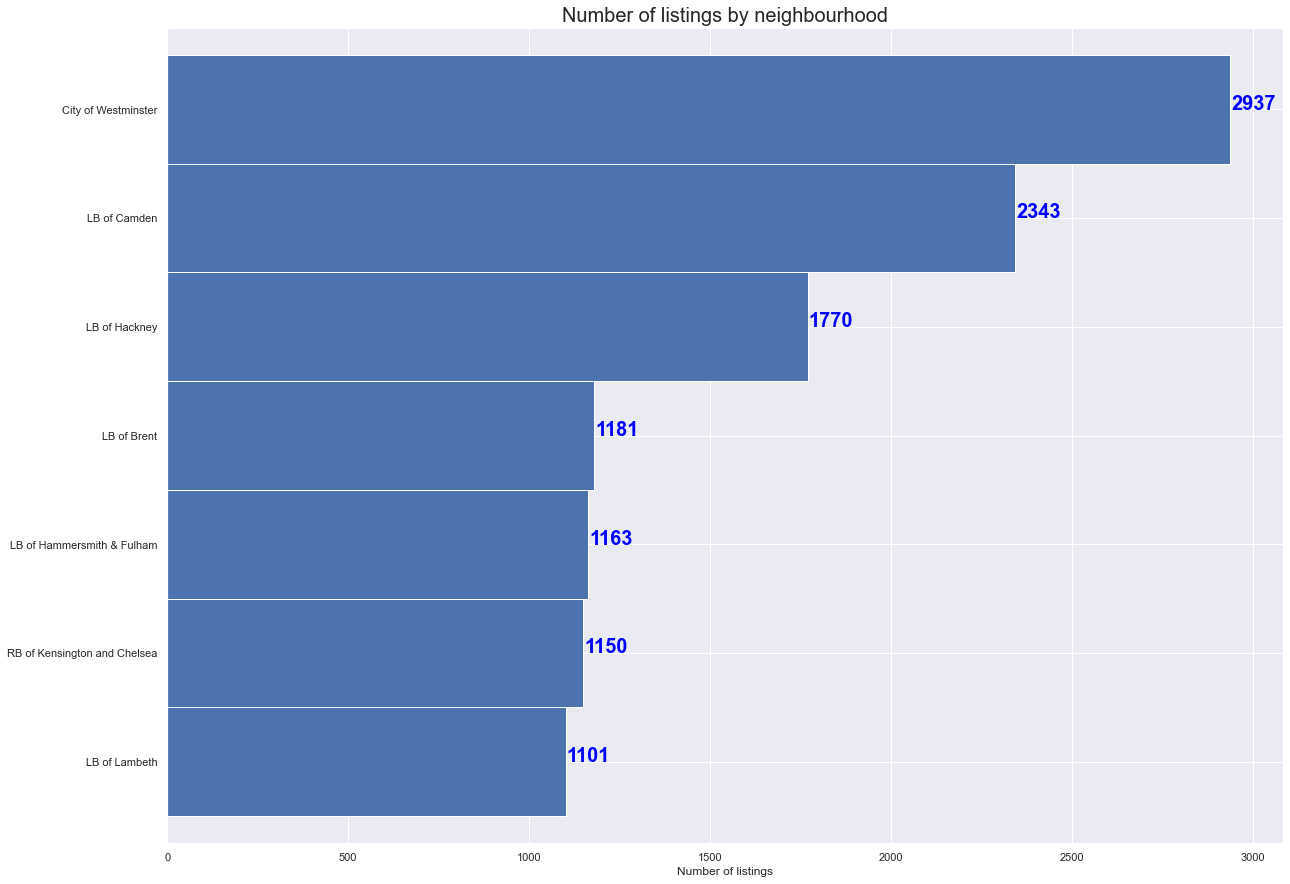

In [35]:
feq=localized_neighborhood_subset.sort_values(ascending=True)
ax = feq.plot.barh(figsize=(20, 15), color='b', width=1)
y =reversed(localized_neighborhood_subset.values)
for i, v in enumerate(y):
    ax.text(x=v + 3, y=i, s=str(v), color='blue', fontweight='bold',fontsize=20)
    
plt.title("Number of listings by neighbourhood", fontsize=20)
plt.xlabel('Number of listings', fontsize=12)
plt.show()

City of Westminister seems to be the most populated one, what happens if we zoom in?

In [41]:
# we create a descriptor function. This will be used in the callback javascript function.
def descriptor_field(x):
    descriptor = 'Listing name: {}<br>Night Cost: <b>{}</b><br>Review Counts: {}<br>Room Type: {}<br>Link: {}'.format(x['name'],x['night_cost'],x['reviews_count'],x['room_type_category'],x['link'])
    return descriptor
df_london['description_listing'] = df_london.apply(descriptor_field, axis=1)#, args=(df2, )

In [45]:
df_london_westminister = df_london[df_london.localized_neighborhood=='City of Westminster'].copy() # make map only of subset of results.
westmister_coord = [51.494720,-0.135278] # we get westmister coordinates

locations = list(zip(df_london_westminister['lat'].tolist(), df_london_westminister['lng'].tolist()))


map1 = folium.Map(location=westmister_coord, 
 zoom_start=13)
               
callback = ('function (row) {' 
                'var marker = L.marker(new L.LatLng(row[0], row[1]), {color: "red"});'
                'var icon = L.AwesomeMarkers.icon({'
                "icon: 'home',"
                "iconColor: 'white',"
                "markerColor: 'blue',"
                "prefix: 'glyphicon',"
                "extraClasses: 'fa-rotate-0'"'});'
                'marker.setIcon(icon);'
                "var popup = L.popup({maxWidth: '500'});"
                "const display_text = {text: row[2]};"
                "var mytext = $(`<div id='mytext' class='display_text' style='width: 100.0%; height: 100.0%;'> ${display_text.text}</div>`)[0];"
                "popup.setContent(mytext);"
                "marker.bindPopup(popup);"
                'return marker};')
                             
map1.add_child(FastMarkerCluster(df_london_westminister[['lat', 'lng','description_listing']].values.tolist(), callback=callback))

#### Checking prices


Ok, we have Westminister has the most number of listings, I wonder if they also have the most expensive listings? Let's check the average price per listings across all neighbours.

In [69]:
df_price = df_london[['localized_neighborhood','reviews_count','preview_amenities','night_cost','room_type_category']].copy()
df_price = df_price[df_price.localized_neighborhood!='0'] # we remove empty neighbourhood

In [71]:
df = df_price.groupby(['localized_neighborhood'])['night_cost'].aggregate(['count','mean','median','max','min']).sort_values(by=['median','mean'],ascending=False)
df

,count,mean,median,max,min
localized_neighborhood,,,,,
Knightsbridge,249,388.088353,240.0,7000.0,50.0
Belgravia,136,374.360294,195.5,3872.0,48.0
The West End,913,236.199343,166.0,17766.0,15.0
Earls Court,946,244.540169,147.0,7000.0,24.0
Clapham,4,216.500000,145.0,546.0,30.0
...,...,...,...,...,...
Roehampton,33,378.484848,37.0,5000.0,14.0
Hammersmith,1,35.000000,35.0,35.0,35.0
Honor Oak,15,64.800000,34.0,243.0,24.0


In [59]:
print('{} apperas to be the most expensive neighborhood with a mean price of {} and a median {}.'.format(df.index[0],df.iloc[0]['mean'],df.iloc[0]['median']))
print('FYI, our initial candidate:')
df[df.index=='City of Westminster']

Knightsbridge apperas to be the most expensive neighborhood with a mean price of 388.0883534136546 and a median 240.0.
FYI, our initial candidate:


,count,mean,median,max,min
localized_neighborhood,,,,,
City of Westminster,2937,210.944842,129.0,7000.0,15.0


And if we plot our top 5 neighborhood, we can see they all follow a left skewed distribution. It also seems like our candidate Westminister contain the majority of overpriced listings.

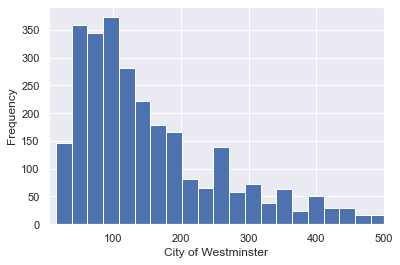

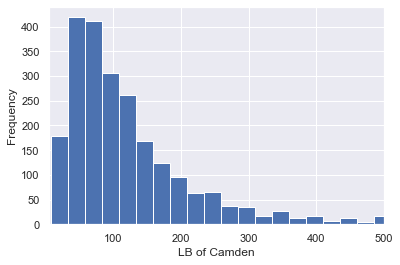

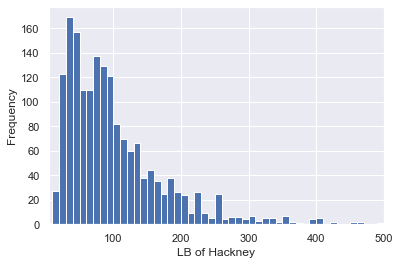

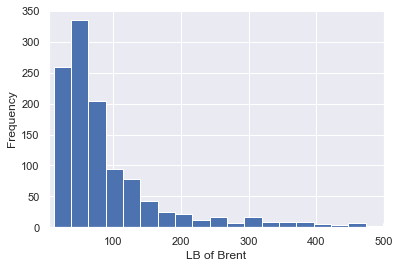

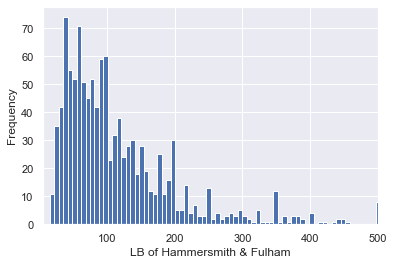

In [68]:
for localized_neighborhood in localized_neighborhood_subset.index[:5]:
    fig, ax = plt.subplots(1)
    df_price[df_price['localized_neighborhood']==localized_neighborhood]['night_cost'].plot.hist(bins=300)
    plt.xlim([5, 500])
    plt.xlabel(localized_neighborhood)
    plt.show()

I've lived 7 years in the UK, yet I never knew that London and City of London meant two different things, apparently it's like some sort of Vatican of finance they got going inside City of London. It has its own government, its own mayor and its own independent police force.

In [77]:
df_london.groupby(['localized_city','localized_neighborhood'])['id'].count().sort_values(ascending=False).head(20)

localized_city  localized_neighborhood      
Greater London  City of Westminster             2106
                LB of Camden                    1543
                LB of Hackney                   1074
                LB of Brent                      780
                RB of Kensington and Chelsea     756
London          City of Westminster              745
                LB of Camden                     720
Greater London  LB of Hammersmith & Fulham       694
London          LB of Hackney                    646
Greater London  LB of Lambeth                    644
                Earls Court                      619
                LB of Islington                  596
                LB of Barnet                     594
                LB of Haringey                   573
                The West End                     549
                LB of Ealing                     502
                Chelsea                          485
                Whitechapel/Brick Lane           461
 

 I can see neighborhoods being labelled as 'Greater London' as well as 'London', an interesting question would be checking if difference in price in the same neighborhood can also be explained by being in 'City of London' or 'Greater London'. Let's see.

In [164]:
df_neighborhood_london = df_london[(df_london.localized_city.isin(['Greater London','London'])) & (df_london.localized_neighborhood.isin(localized_neighborhood_subset.index.tolist()))][['localized_city', 'localized_neighborhood','night_cost']].copy()
df_neighborhood_london = df_neighborhood_london.groupby(['localized_city','localized_neighborhood']).mean().reset_index().sort_values(by=['localized_neighborhood'])
df_neighborhood_london['change'] = df_neighborhood_london['night_cost'].shift(1) 
df_neighborhood_london['difference_price'] = df_neighborhood_london['night_cost'] - df_neighborhood_london['change']
df_neighborhood_london = df_neighborhood_london[df_neighborhood_london['localized_city'] =='London'].drop(['localized_city'],axis=1)
df_neighborhood_london.columns = ['localized_neighborhood','city_london_cost','greater_lond_cost','price_change']
df_neighborhood_london

,localized_neighborhood,city_london_cost,greater_lond_cost,price_change
7,City of Westminster,217.306040,205.189459,12.116582
8,LB of Brent,120.996516,110.241026,10.755490
9,LB of Camden,169.551389,138.455606,31.095783
10,LB of Hackney,113.766254,120.106145,-6.339891
11,LB of Hammersmith & Fulham,130.662679,144.546110,-13.883430
12,LB of Lambeth,117.076543,123.324534,-6.247991
13,RB of Kensington and Chelsea,176.002817,208.030423,-32.027606


It doesn't seem to be a pattern here, only 3 of the top 7 neighborhood seem to have a higher price in the City of London compared to Greater London. In addition, the difference per se is not major in price (excluding Camden and Kensington and Chelsea). We can then Greater London and London for the purpose of explaining price won't make much difference (if we are looking at the same neighborhood).

### 3.3. Room, property and ammendities types<a class="anchor" id="explore"></a>

Majority of airbnb listings in London appear to be apartment and private rooms. Same thing for Belfast

In [413]:
df_london_room = df_london[df_london.localized_city.isin(['Greater London','London'])]['room_type'].value_counts().reset_index()
df_london_room['city'] = 'London'
df_belfast_room = df_belfast[df_belfast.localized_city.isin(['Belfast'])]['room_type'].value_counts().reset_index()
df_belfast_room['city'] = 'Belfast'
df_city_rooms = pd.concat([df_london_room,df_belfast_room])
df = df_city_rooms.groupby(['index','city']).min().T
df['Hotel room','Belfast'] = 0
df['Shared room','Belfast'] = 0
df

index     Entire home/apt        Hotel room Private room        Shared room  \
city              Belfast London     London      Belfast London      London   
room_type             435  19178        409          246  12781         265   

index     Hotel room Shared room  
city         Belfast     Belfast  
room_type          0           0

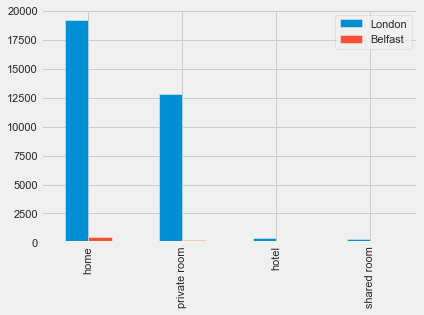

In [441]:
_ = (pd.DataFrame(np.c_[(df['Entire home/apt'][['London','Belfast']].values[0],df['Private room'][['London','Belfast']].values[0],df['Hotel room'].values[0],df['Shared room'].values[0])].T,index=['home','private room','hotel','shared room'],columns=['London','Belfast']))
_.plot.bar()
plt.show()

Our original dataset has also property_type_id. The problem here is that we need to map those id values (provided by in the json response) to the actual text that in the end is displayed to the user. Again, Steve's website has been proven a quite useful resource as they've already done that mapping for us.

In [449]:
mapping = {
1:'Apartment',
2:'House',
3:'Bed and breakfast',
4:'Cabin',
5:'Castle',
6:'Treehouse',
8:'Boat',
10:'Lighthouse',
11:'Villa',
12:'Igloo',
15:'Yurt',
16:'Tipi',
17:'Dome house',
18:'Cave',
19:'Island',
22:'Chalet',
23:'Earth house',
24:'Hut',
25:'Train',
28:'Plane',
32:'Camper/RV',
34:'Tent',
35:'Loft',
36:'Townhouse',
38:'Bungalow',
40:'Guesthouse',
42:'Hotel',
43:'Boutique hotel',
44:'Nature lodge',
45:'Hostel',
47:'Serviced apartment',
48:'Minsu(Taiwan)',
49:'Ryokan(Japan)',
50:'Pension(South Korea)',
51:'Heritage hotel(India)',
53:'Guest suite',
54:'Casa particular (Cuba)',
55:'Pousada (Portugal)',
57:'Barn',
58:'Campsite',
60:'Cottage',
61:'Cycladic house (Greece)',
62:'Dammuso (Italy)',
63:'Farm stay',
64:'Houseboat',
65:'Resort',
66:'Shepherd’s hut (U.K.,:France)',
67:'Tiny house',
68:'Trullo (Italy)',
69:'Windmill',
33:'Private room',
37:'Entire condominium',
56:'Room in aparthotel'
}
df_london['property_type_value'] = df_london.property_type_id.map(mapping)

In [457]:
print('In total we can see that there are {} property types. That\'s far too many for any meaningful visualization. Let\'s visualize only on top 5.'.format(df_london.property_type_value.value_counts().shape[0]))
df_property_type = df_london[df_london.property_type_value.isin(list(df_london.property_type_value.value_counts().head(5).index))].copy()

In total we can see that there are 36 property types. That's far too many for any meaningful visualization. Let's visualize only on top 5.


((32564, 36), (35556, 36))

Apartment             20776
House                  8042
Townhouse              1438
Entire condominium     1167
Serviced apartment     1141
Name: property_type_value, dtype: int64


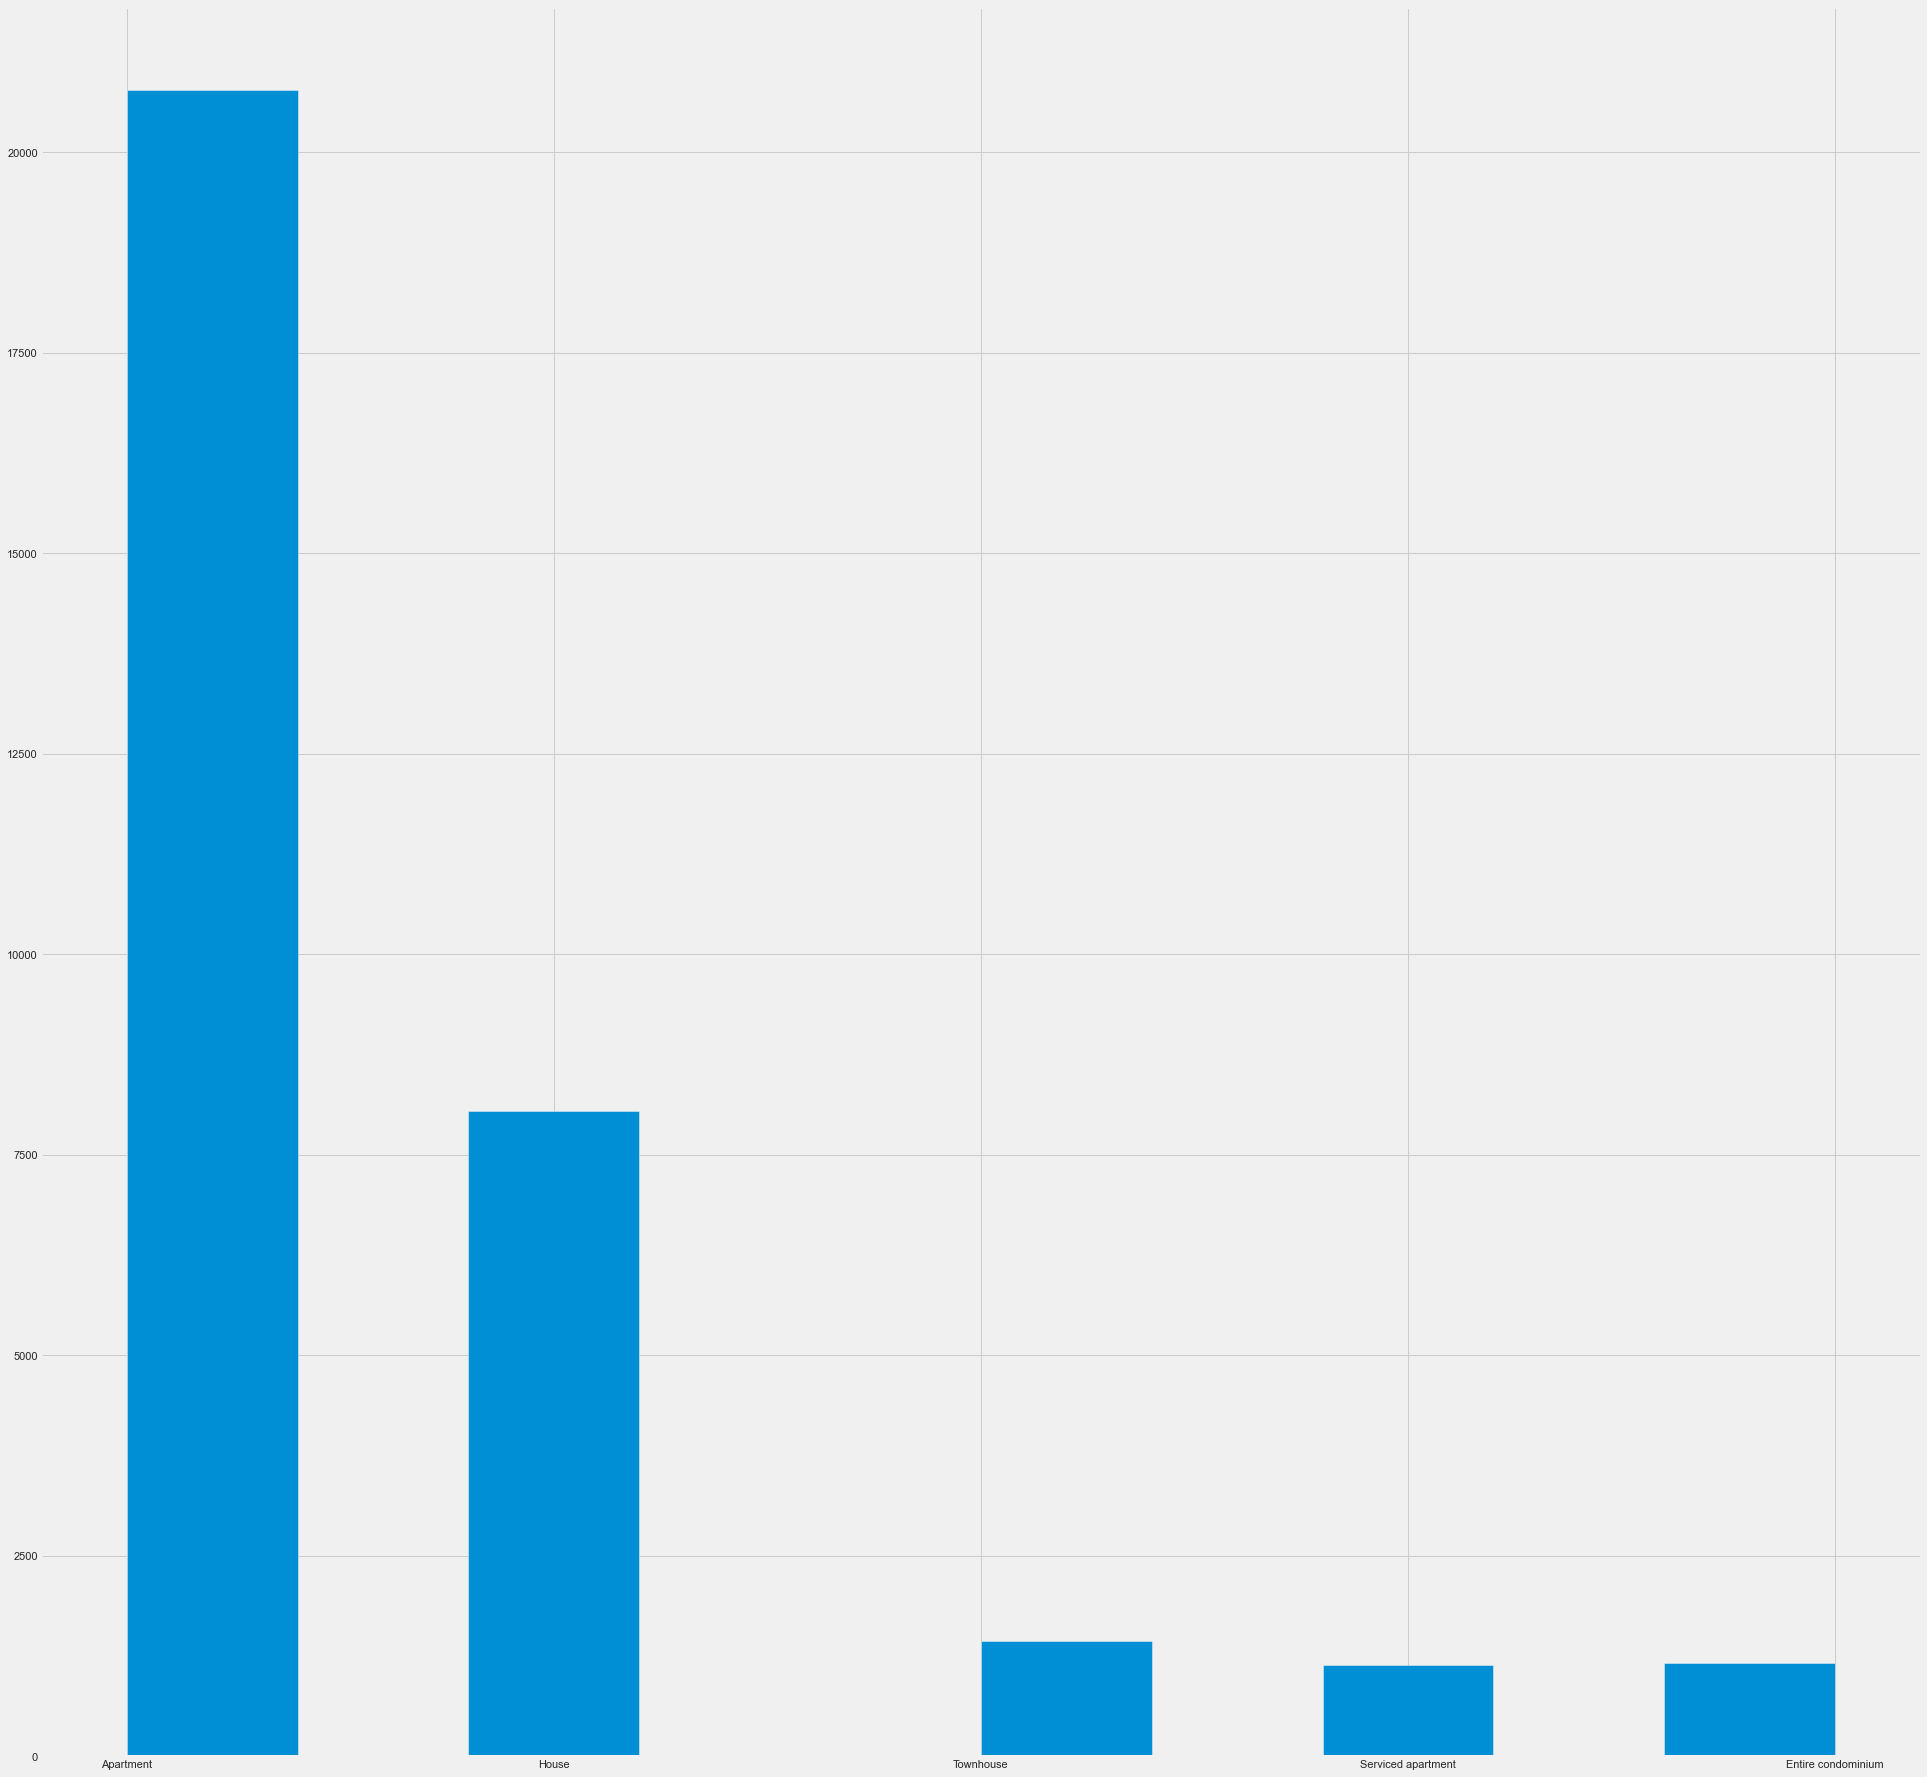

In [461]:
print(df_property_type.property_type_value.value_counts())
df_property_type.property_type_value.hist(figsize=(30,30))

As we would expect, apartment and house make the the majority of the listings. No surprise there as basically almost all listings in airbnb London have to do with private rooms and entire appartments.

### 3.3. Proporty types <a class="anchor" id="explore"></a>

## 3.1.Exploring the data <a class="anchor" id="explore"></a>

## 3.1.Exploring the data <a class="anchor" id="explore"></a>